### Load the data and libraries

In [1]:
from pathlib import Path
import pandas as pd

DATA_PATH = Path("../input/mnist-in-csv")

In [2]:
train = pd.read_csv(DATA_PATH / 'mnist_train.csv') 
test = pd.read_csv(DATA_PATH / 'mnist_test.csv')

In [3]:
train.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Organize the data into a suitable format

In [5]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train, test_size=0.1, stratify=train['label'])
train.reset_index(inplace=True, drop=True)
valid.reset_index(inplace=True, drop=True)

In [6]:
x_train, y_train = train.iloc[:, 1:].values , train.iloc[:, 0].values
x_val, y_val = valid.iloc[:, 1:].values , valid.iloc[:, 0].values
x_test = test.iloc[:, :].values

In [7]:
import gc

In [8]:
del train, test, valid
gc.collect()

150

In [9]:
from matplotlib import pyplot as plt
import numpy as np

(54000, 784)


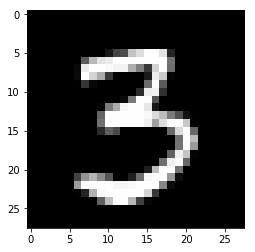

In [10]:
# chech the data
plt.imshow(x_train[0].reshape((28,28)), cmap='gray')
print(x_train.shape)

In [11]:
# convert the data to tensors inorder to use pytorch
import torch
x_train,x_val, x_test = map(torch.FloatTensor, (x_train,x_val, x_test))
n, c = x_train.shape
y_train, y_val = map(torch.IntTensor, (y_train, y_val))

In [12]:
# initialize the weights and bias
import math
weights = torch.randn((784,10)) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

### Create our model

In [13]:
### in pytorch any function or object can act asa model

In [14]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [15]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)

In [16]:
def nll(input, target):
    return -input[range(target.type(torch.long).shape[0]), target.type(torch.long)].mean()

loss_func = nll

In [17]:
# calculate the loss
yb = y_train[0:bs]
loss_func(preds, yb)

tensor(inf, grad_fn=<NegBackward>)

In [18]:
# function for accuracy
def accuracy(out,yb):
    preds = torch.argmax(out,dim=1)
    return (preds == yb.type(torch.long)).float().mean()

In [19]:
print(accuracy(preds, yb))

tensor(0.1406)


In [20]:
# let's write our training loop
lr_rate = 0.5
epochs = 3

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        starti = i * bs
        endi = starti + bs
        xb = x_train[starti: endi]
        yb = y_train[starti: endi]
        loss = loss_func(model(xb), yb)
        
        loss.backward()        
        with torch.no_grad():
            weights -= weights.grad * lr_rate
            bias -= bias.grad * lr_rate
            weights.grad.zero_()
            bias.grad.zero_()            

In [21]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NegBackward>) tensor(0.0417)


In [22]:
## let's use the torch.nn.functional module which conatains many torch functions 

In [23]:
# cross-entropy loss is a combination of logsoftmax and nll 

In [24]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

In [25]:
print(loss_func(model(xb), yb.type(torch.long)), accuracy(model(xb), yb))

tensor(nan, grad_fn=<NllLossBackward>) tensor(0.0417)


In [26]:
## let's use the nn.Module and nn.Parameter

In [27]:
from torch import nn

In [28]:
class MNIST_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((784,10)) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10)) # requires grad is taken care of
        
    def forward(self, xb):
        return xb @ self.weights + self.bias

In [29]:
model = MNIST_logistic() # the class can be used as a function and forward is automaticaly called

In [30]:
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(119.1691, grad_fn=<NllLossBackward>) tensor(0.0833)


In [31]:
def fit(lr_rate, epochs):
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            starti = i * bs
            endi = starti + bs
            xb = x_train[starti: endi]
            yb = y_train[starti: endi]
            loss = loss_func(model(xb), yb.type(torch.long))

            loss.backward()        
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr_rate
                model.zero_grad() # all parmaters grad is made 0
                
fit(0.05, 2)

In [32]:
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(72.5121, grad_fn=<NllLossBackward>) tensor(0.9583)


In [33]:
# refactor our model
class MNIST_logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10) # take care of initialization and requires grad 
        
    def forward(self, xb):
        return self.lin(xb)

In [34]:
model = MNIST_logistic()
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(74.6374, grad_fn=<NllLossBackward>) tensor(0.0417)


In [35]:
fit(0.05, 2)
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(319.9439, grad_fn=<NllLossBackward>) tensor(0.9375)


# refactor using torch.optim

In [36]:
from torch import optim

In [37]:
def get_model(lr):
    model = MNIST_logistic()
    return model, optim.RMSprop(model.parameters(), lr=lr)

model,opt = get_model(0.05)

def fit(epochs):
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            starti = i * bs
            endi = starti + bs
            xb = x_train[starti: endi]
            yb = y_train[starti: endi]
            loss = loss_func(model(xb), yb.type(torch.long))
            loss.backward()       
            opt.step() #for all parms take forward step
            opt.zero_grad() # zerod the grads for next batch

In [38]:
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(59.1030, grad_fn=<NllLossBackward>) tensor(0.1667)


In [39]:
fit(2)
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(23.0636, grad_fn=<NllLossBackward>) tensor(0.9583)


In [40]:
# refactor using dataset
from torch.utils.data import TensorDataset # dataset wrapper aroung tensors

In [41]:
train_ds = TensorDataset(x_train, y_train)

In [42]:
model,opt = get_model(0.05)

def fit(epochs):
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            xb, yb = train_ds[i*bs: i*bs+bs]
            loss = loss_func(model(xb), yb.type(torch.long))
            loss.backward()       
            opt.step() #for all parms take forward step
            opt.zero_grad() # zerod the grads for next batch

In [43]:
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(84.8455, grad_fn=<NllLossBackward>) tensor(0.0833)


In [44]:
fit(2)
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(50.7047, grad_fn=<NllLossBackward>) tensor(0.9583)


In [45]:
# refactor using dataloader
from torch.utils.data import DataLoader

In [46]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=80)

In [47]:
model,opt = get_model(0.05)

def fit(epochs):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb.type(torch.long))
            loss.backward()       
            opt.step() #for all parms take forward step
            opt.zero_grad() # zerod the grads for next batch

In [48]:
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(77.6245, grad_fn=<NllLossBackward>) tensor(0.1042)


In [49]:
fit(2)
print(loss_func(model(xb),yb.type(torch.long)), accuracy(model(xb),yb))

tensor(47.4212, grad_fn=<NllLossBackward>) tensor(0.9167)


In [50]:
# let's put up a validatin set

In [51]:
# important to shuffle training data to prevent correlation in minibaches but validation shuffling is not needed

In [52]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_ds = TensorDataset(x_val, y_val)
valid_dl = DataLoader(valid_ds, batch_size=2*bs)

In [53]:
model,opt = get_model(0.05)

def fit(epochs):
    for epoch in range(epochs):
        model.train() # imp to put for traning and eval time for batchnorm and dropout
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb.type(torch.long))
            loss.backward()       
            opt.step() #for all parms take forward step
            opt.zero_grad() # zerod the grads for next batch
            
        model.eval()
        with torch.no_grad():
            valid_loss = sum(loss_func(model(xb), yb.type(torch.long)) for xb, yb in valid_dl)
        print(epoch, (valid_loss / len(valid_dl)).item()) # number of minibatches
fit(4)

0 281.6712951660156
1 223.49269104003906
2 199.86712646484375
3 232.7772979736328


In [54]:
# more refactoring 

In [55]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=2*bs))

def loss_batch(model, loss_func,xb, yb,opt=None):
    loss = loss_func(model(xb), yb.type(torch.long))
    
    if opt:
        loss.backward()
        opt.step() #for all parms take forward step
        opt.zero_grad() # zerod the grads for next batch
    return loss.item(), len(xb)

In [56]:
import numpy as np
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train() # imp to put for traning and eval time for batchnorm and dropout
        tr_losses, tr_bsz = [], []
        for xb, yb in train_dl:
            loss, bs = loss_batch(model, loss_func, xb, yb, opt)
            tr_losses.append(loss); tr_bsz.append(bs)
            
        model.eval()
        with torch.no_grad():
            losses, bsz = zip(*(loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl))
        valid_loss = np.sum(np.multiply(losses, bsz)) / np.sum(bsz)
        train_loss = np.sum(np.multiply(tr_losses, tr_bsz)) / np.sum(tr_bsz)
        print(f"epoch:{epoch}", f'train_loss:{train_loss}',f'valid_loss:{valid_loss}')            

In [57]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model(0.05)
fit(4, model, loss_func, opt, train_dl, valid_dl)

epoch:0 train_loss:267.0352377771448 valid_loss:245.3351257324219
epoch:1 train_loss:214.4493124762641 valid_loss:228.47414021809897
epoch:2 train_loss:214.78188225244594 valid_loss:249.67978043619792
epoch:3 train_loss:213.51757204635055 valid_loss:279.5303752441406


In [58]:
# let's switch to a CNN

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

In [59]:
model = MNIST_CNN()
opt = optim.Adam(model.parameters(), lr=0.05, betas=(0.8, 0.7))

fit(4, model, loss_func, opt, train_dl, valid_dl)

epoch:0 train_loss:1.8894874581231011 valid_loss:1.5759652614593507
epoch:1 train_loss:1.6056821239259509 valid_loss:1.7554696782430013
epoch:2 train_loss:1.605747270937319 valid_loss:1.6840614191691081
epoch:3 train_loss:1.6150890464782715 valid_loss:1.675480343500773


In [60]:
# refactor using nn.Sequential
# define custm layer using function

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def reshape(x):
    return x.view(-1, 1, 28, 28)

In [61]:
model = nn.Sequential(
                    Lambda(reshape),
                    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.AvgPool2d(4),
                    Lambda(lambda x: x.view(x.size(0), -1))   
                     )
opt = optim.Adam(model.parameters(), lr=0.05, betas=(0.8, 0.7))

fit(4, model, loss_func, opt, train_dl, valid_dl)

epoch:0 train_loss:2.3959516685627125 valid_loss:2.3025827452341714
epoch:1 train_loss:2.302583456463284 valid_loss:2.3025827452341714
epoch:2 train_loss:2.302583456463284 valid_loss:2.3025827452341714
epoch:3 train_loss:2.302583456463284 valid_loss:2.3025827452341714


In [62]:
# wrapping the dataloader
class WrapperDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield self.func(*b)
            
def reshape(x, y):
    return x.view(-1, 1, 28, 28), y

In [63]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, reshape)
valid_dl = WrapperDataLoader(valid_dl, reshape)

In [64]:
model = nn.Sequential(
                    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool2d(1),
                    Lambda(lambda x: x.view(x.size(0), -1))   
                     )
opt = optim.Adam(model.parameters(), lr=0.05, betas=(0.8, 0.7))

fit(4, model, loss_func, opt, train_dl, valid_dl)

epoch:0 train_loss:2.3236872588970043 valid_loss:2.3025827452341714
epoch:1 train_loss:2.302583456463284 valid_loss:2.3025827452341714
epoch:2 train_loss:2.302583456463284 valid_loss:2.3025827452341714
epoch:3 train_loss:2.302583456463284 valid_loss:2.3025827452341714


In [65]:
# set up device
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [66]:
# refactor code to use GPU
def reshape(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrapperDataLoader(train_dl, reshape)
valid_dl = WrapperDataLoader(valid_dl, reshape)

In [67]:
model = nn.Sequential(
                    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
                    nn.ReLU(),
                    nn.AdaptiveAvgPool2d(1),
                    Lambda(lambda x: x.view(x.size(0), -1))   
                     )
model.to(dev)
opt = optim.Adam(model.parameters(), lr=0.05, betas=(0.8, 0.7))
fit(4, model, loss_func, opt, train_dl, valid_dl)

epoch:0 train_loss:2.445718612247043 valid_loss:2.3025849043528237
epoch:1 train_loss:2.3025848859151203 valid_loss:2.3025849043528237
epoch:2 train_loss:2.3025848859151203 valid_loss:2.3025849043528237
epoch:3 train_loss:2.3025848859151203 valid_loss:2.3025849043528237
